In [1]:
import sys
import os
import importlib   

sys.path.append(os.path.join(os.getcwd(), 'NeuralNetworks'))
import multiLayerNN as FC
importlib.reload(FC)

import torch
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(15)
torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def u_exact(x:torch.Tensor):
    # u_g = torch.log(x+2) + torch.cos(2*x + x**3)
    u_g = torch.sin(2*x + 1) + 0.2*torch.exp(1.3*x)
    # u_g = x**3/(0.01 + x**4)
    return u_g

In [4]:
def calculate_kappa(x):
    nb_zeros = torch.where(x[0:-1, 0] * x[1:, 0] < 0)[0]
    kappa = 3*(nb_zeros.shape[0])
    return kappa

In [39]:
class OneStageFCNN():
    def __init__(self, x_train, u_train, hidden_size, kappa, lower_bound, upper_bound, activation_func):
        super(OneStageFCNN, self).__init__()

        assert isinstance(x_train, torch.cuda.DoubleTensor)
        assert isinstance(u_train, torch.cuda.DoubleTensor)
        
        # self.u_scale = torch.sqrt(torch.mean(u_train**2))
        self.u_scale = torch.max(torch.abs(u_train))
        self.loss_scale = self.u_scale**2
        self.x_train = x_train
        self.u_train = u_train/self.u_scale

        self.hidden_size = hidden_size
        self.kappa = kappa
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.activation_func = activation_func

        self.model = FC.FullyConnectedNetwork(domain_bounds=[lower_bound, upper_bound], kappa=kappa, input_dim=1, hidden_size=hidden_size, actv=activation_func).to(device)
        self.model_optimizer = 'defined in train'
        self.loss_criterion = 'defined in train'

    def _adam_train(self, n_iter):
        loss_criterion = self.loss_criterion
        model_optimizer = self.model_optimizer

        for iter_i in range(n_iter):
            model_optimizer.zero_grad()
            u_pred = self.model(self.x_train)
            loss_value = loss_criterion(u_pred, self.u_train)
            loss_value.backward(retain_graph=True)
            model_optimizer.step()

            if iter_i % 100 == 0:
                print(f"Iteration {iter_i}, Loss: {loss_value*self.loss_scale}")

    def _closure(self):
        self.model_optimizer.zero_grad()
        u_pred = self.model(self.x_train)
        loss_value = self.loss_criterion(u_pred, self.u_train)
        loss_value.backward(retain_graph=True) 
        return loss_value
    
    def _lbfgs_train(self, n_iter):
        for iter_i in range(n_iter):
            loss_value = self.model_optimizer.step(self._closure)
            if iter_i % 100 == 0:
                print(f"Iteration {iter_i}, Loss: {loss_value*self.loss_scale}")

    def train(self, n_iter, method):
        self.loss_criterion = torch.nn.MSELoss()
        if method == 1:
            self.model_optimizer = torch.optim.Adam(self.model.parameters(), lr=0.0005)
            self._adam_train(n_iter)
        elif method == 2:
            max_iter = torch.tensor(n_iter / 3, dtype=torch.float32)
            self.model_optimizer = torch.optim.LBFGS(self.model.parameters(), lr=0.0005, max_iter=max_iter, line_search_fn='strong_wolfe')
            self._lbfgs_train(n_iter)

    def predict(self, x_to_predict):
        u_pred = self.model(x_to_predict) * self.u_scale
        return u_pred

In [34]:
nb_training_points = 1501
x_train = torch.linspace(-1.02, 1.02, nb_training_points).reshape(-1,1).to(device)
u_train = u_exact(x_train)

low_bound_xtrain, up_bound_xtrain = x_train.min(), x_train.max()

nb_evaluation_points = 8000
x_eval = torch.linspace(-1, 1, nb_evaluation_points).reshape(-1,1).to(device)
u_eval = u_exact(x_eval)

In [40]:
# Fist stage of training

model1 = OneStageFCNN(x_train, u_train, hidden_size=20, kappa=1, lower_bound=low_bound_xtrain, upper_bound=up_bound_xtrain, activation_func=0)
model1.train(9000, 1)
model1.train(1000, 2)
u_p = model1.predict(x_eval)

Iteration 0, Loss: 0.6808619388375278
Iteration 100, Loss: 0.08635347126023948
Iteration 200, Loss: 0.0614081990401613
Iteration 300, Loss: 0.011747864450364107
Iteration 400, Loss: 0.004273571342014389
Iteration 500, Loss: 0.0034984403977058503
Iteration 600, Loss: 0.0030297080086344394
Iteration 700, Loss: 0.0026569891041201515
Iteration 800, Loss: 0.002346258349866075
Iteration 900, Loss: 0.002082604366772443
Iteration 1000, Loss: 0.001855622529246549
Iteration 1100, Loss: 0.0016577559898827803
Iteration 1200, Loss: 0.0014832901687276622
Iteration 1300, Loss: 0.0013276794503256034
Iteration 1400, Loss: 0.0011873335149512499
Iteration 1500, Loss: 0.001059535057329246
Iteration 1600, Loss: 0.000942286705978908
Iteration 1700, Loss: 0.0008341312181774192
Iteration 1800, Loss: 0.0007340125587401696
Iteration 1900, Loss: 0.0006411883714300384
Iteration 2000, Loss: 0.000555175680074129
Iteration 2100, Loss: 0.0004757105282692423
Iteration 2200, Loss: 0.0004027087190365741
Iteration 2300, 

In [41]:
# Second stage of the training

u_train2 = u_train - model1.predict(x_train)
kappa2 = calculate_kappa(u_train2)

model2 = OneStageFCNN(x_train, u_train2, hidden_size=20, kappa=kappa2, lower_bound=low_bound_xtrain, upper_bound=up_bound_xtrain, activation_func=1)
model2.train(20000, 1)
model2.train(2000, 2)
u_pred2 = model2.predict(x_eval)
u_p2 = u_p + u_pred2

Iteration 0, Loss: 2.567203060987663e-05
Iteration 100, Loss: 2.1912008325353348e-07
Iteration 200, Loss: 4.548625070521718e-08
Iteration 300, Loss: 1.4838355972422139e-08
Iteration 400, Loss: 7.705692516711241e-09
Iteration 500, Loss: 5.1343746081963864e-09
Iteration 600, Loss: 3.8505521514699045e-09
Iteration 700, Loss: 3.045745672726839e-09
Iteration 800, Loss: 2.4793745795450346e-09
Iteration 900, Loss: 2.06270624905664e-09
Iteration 1000, Loss: 1.742139097884108e-09
Iteration 1100, Loss: 1.491918141644132e-09
Iteration 1200, Loss: 1.2917739723829908e-09
Iteration 1300, Loss: 1.128964630207695e-09
Iteration 1400, Loss: 1.0084786576700434e-09
Iteration 1500, Loss: 8.841055303254297e-10
Iteration 1600, Loss: 7.890425446503298e-10
Iteration 1700, Loss: 7.066470485666238e-10
Iteration 1800, Loss: 6.346174937217216e-10
Iteration 1900, Loss: 5.721937457151065e-10
Iteration 2000, Loss: 5.16812767897191e-10
Iteration 2100, Loss: 4.673940004143622e-10
Iteration 2200, Loss: 4.232218684602414

In [42]:
# Third stage of the training
nb_training_points_strengthening = 4801
x_train_strengthening = torch.linspace(-1.02, 1.02, nb_training_points_strengthening).reshape(-1,1).to(device)
u_train_strengthening = u_exact(x_train_strengthening)

u_train3 = u_train_strengthening - model1.predict(x_train_strengthening) - model2.predict(x_train_strengthening)
kappa3 = calculate_kappa(u_train3)

model3 = OneStageFCNN(x_train_strengthening, u_train3, hidden_size=30, kappa=kappa3, lower_bound=low_bound_xtrain, upper_bound=up_bound_xtrain, activation_func=1)
model3.train(25000, 1)
model3.train(5000, 2)
u_pred3 = model3.predict(x_eval)
u_p3 = u_p2 + u_pred3

Iteration 0, Loss: 4.0686236350136283e-10
Iteration 100, Loss: 3.098302887766307e-12
Iteration 200, Loss: 1.8024538517310241e-12
Iteration 300, Loss: 1.2887346675748362e-12
Iteration 400, Loss: 9.407461914970878e-13
Iteration 500, Loss: 7.305915576202562e-13
Iteration 600, Loss: 5.894442177846506e-13
Iteration 700, Loss: 4.842134119324837e-13
Iteration 800, Loss: 4.0103698438844694e-13
Iteration 900, Loss: 3.34951049350498e-13
Iteration 1000, Loss: 2.833840061208637e-13
Iteration 1100, Loss: 2.433928353417818e-13
Iteration 1200, Loss: 2.1206679800095618e-13
Iteration 1300, Loss: 1.8703084343700775e-13
Iteration 1400, Loss: 1.6655047815469217e-13
Iteration 1500, Loss: 1.4941194228830916e-13
Iteration 1600, Loss: 1.3477036442750422e-13
Iteration 1700, Loss: 1.220285789227359e-13
Iteration 1800, Loss: 1.10758729940056e-13
Iteration 1900, Loss: 1.0065441457034462e-13
Iteration 2000, Loss: 1.0342282668785838e-13
Iteration 2100, Loss: 8.324335234181118e-14
Iteration 2200, Loss: 7.56195218125

In [43]:
# Fourth stage of the training
u_train4 = u_train_strengthening - model1.predict(x_train_strengthening).detach() - model2.predict(x_train_strengthening).detach() - model3.predict(x_train_strengthening).detach()
kappa4 = calculate_kappa(u_train4)

model4 = OneStageFCNN(x_train_strengthening, u_train4, hidden_size=30, kappa=kappa4, lower_bound=low_bound_xtrain, upper_bound=up_bound_xtrain, activation_func=1)
model4.train(30000, 1)
model4.train(5000, 2)
u_pred4 = model4.predict(x_eval)

u_p4 = u_p3 + u_pred4

Iteration 0, Loss: 7.678994581339686e-14
Iteration 100, Loss: 1.6039095012451003e-15
Iteration 200, Loss: 9.926218715011155e-16
Iteration 300, Loss: 6.847890612706886e-16
Iteration 400, Loss: 5.1958838167133655e-16
Iteration 500, Loss: 4.2559477423206886e-16
Iteration 600, Loss: 3.682187983731264e-16
Iteration 700, Loss: 3.3014682602115686e-16
Iteration 800, Loss: 3.030670158779766e-16
Iteration 900, Loss: 2.828706430155742e-16
Iteration 1000, Loss: 2.6715342066035373e-16
Iteration 1100, Loss: 2.5451391867783895e-16
Iteration 1200, Loss: 2.4405566174582793e-16
Iteration 1300, Loss: 2.3517804401779823e-16
Iteration 1400, Loss: 2.274661172526468e-16
Iteration 1500, Loss: 2.2061194037677727e-16
Iteration 1600, Loss: 2.1442623492726367e-16
Iteration 1700, Loss: 2.0873472206890093e-16
Iteration 1800, Loss: 2.0341414441634236e-16
Iteration 1900, Loss: 1.9843441539817949e-16
Iteration 2000, Loss: 1.9349287917376147e-16
Iteration 2100, Loss: 1.8871092757340666e-16
Iteration 2200, Loss: 1.83938

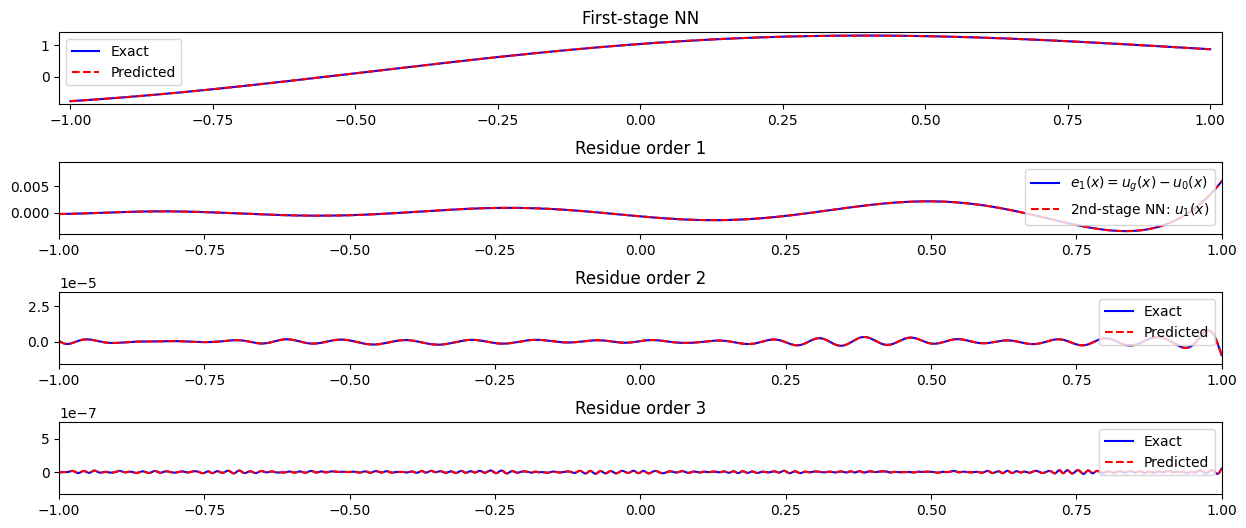

In [44]:
fig, axes = plt.subplots(4, 1, figsize=(15, 6))
fig.subplots_adjust(hspace=0.8)

axes[0].plot(x_eval.cpu(), u_eval.cpu(), 'b-', label='Exact')
axes[0].plot(x_eval.cpu(), u_p.cpu().detach(), 'r--', label='Predicted')
axes[0].set_xlim(low_bound_xtrain.cpu(), up_bound_xtrain.cpu())
axes[0].legend()
axes[0].set_title('First-stage NN')

axes[1].plot(x_train.cpu(), u_train2.cpu().detach(), 'b-', label=r'$e_1(x) = u_g(x) - u_0(x)$')
axes[1].plot(x_eval.cpu(), u_pred2.cpu().detach(), 'r--', label=r'2nd-stage NN: $u_1(x)$')
axes[1].set_xlim(-1, 1)
axes[1].legend()
axes[1].set_title('Residue order 1')

axes[2].plot(x_train_strengthening.cpu(), u_train3.cpu().detach(), 'b-', label='Exact')
axes[2].plot(x_eval.cpu(), u_pred3.cpu().detach(), 'r--', label='Predicted')
axes[2].set_xlim(-1, 1)
axes[2].legend()
axes[2].set_title('Residue order 2')

axes[3].plot(x_train_strengthening.cpu(), u_train4.cpu().detach(), 'b-', label='Exact')
axes[3].plot(x_eval.cpu(), u_pred4.cpu().detach(), 'r--', label='Predicted')
axes[3].set_xlim(-1, 1)
axes[3].legend()
axes[3].set_title('Residue order 3')

plt.show()

In [45]:
import numpy as np 
error_u = np.linalg.norm(u_eval.cpu() - u_p.cpu().detach())/np.linalg.norm(u_eval.cpu(), 2)
error_u2 = np.linalg.norm(u_eval.cpu() - u_p2.cpu().detach())/np.linalg.norm(u_eval.cpu(), 2)
error_u3 = np.linalg.norm(u_eval.cpu() - u_p3.cpu().detach())/np.linalg.norm(u_eval.cpu(), 2)
error_u4 = np.linalg.norm(u_eval.cpu() - u_p4.cpu().detach())/np.linalg.norm(u_eval.cpu(), 2)

print(f'Error of order 1: {error_u}')
print(f'Error of order 2: {error_u2}')
print(f'Error of order 3: {error_u3}')
print(f'Error of order 4: {error_u4}')

Error of order 1: 0.0014574938776133596
Error of order 2: 1.6362110352663762e-06
Error of order 3: 1.0263398695800836e-08
Error of order 4: 6.407340405421119e-10
